#Homework 5 - Optimization Methods 
Sudarut Kasemsuk

---









#Question 1: Min volume ellipsoid (2pts)
Consider
$$
\varepsilon_0 = \{x:x^{T}P_{0}^{-1}x \leq 1 \} \\
P_{0} = 
\begin{bmatrix}
1 & 0\\
0 & 4
\end{bmatrix}
$$
Construct (give the formula and plot) the min volume ellipsoid that covers: $\varepsilon_0 \cap \{x:Wx \leq 0\}$ for:
* $W = [1;0]$
* $W = [1/2;-1/2]$

Provide $ \frac{vol(\varepsilon)}{vol(\varepsilon_0)}$ for both cases.


**Solution:** \\
Since we have  
$$
P^{-1} = 
\begin{bmatrix}
\frac{1}{a^2} & 0\\
0 & \frac{1}{b^2}
\end{bmatrix}
= \begin{bmatrix}
1 & 0\\
0 & \frac{1}{4}
\end{bmatrix}
$$
then $a = 1, b = 2$ and we have $\frac{x^2}{1} + \frac{x^2}{4} \leq 1$ 

In [1]:
import matplotlib.pyplot as plt

In [ ]:
#Define function for computing gradient of log(det(A)) at x
def grad_logdet(A, x):
  return np.array([[A[0, 0] / np.dot(x.T, np.dot(A, x))],[A[1, 1] / np.dot(x.T, np.dot(A, x))]])

#Define ellipsoid method
def ellipsoid_method(c0, A0, W, tol=1e-4):
  A = A0
  c = c0
  V = np.pi / np.sqrt(np.linalg.det(A))
  while True:
    # Find point on boundary of E intersect W
    x = np.linalg.solve(A, W / np.sqrt(np.dot(W.T, np.dot(np.linalg.inv(A), W))))
    if np.sqrt(np.dot(x.T, np.dot(A, x))) <= 1 + tol:
      break
    # Compute gradient of log(det(A)) at x
    grad = grad_logdet(A, x)
    # Update A and c
    A = A - 2/3 * (np.dot(grad, grad.T) / np.dot(grad.T, grad))
    c = x
    V = np.pi / np.sqrt(np.linalg.det(A))
  return V, c, A

In [ ]:
def plot_ellipsoid(center, A):
  t = np.linspace(0, 2*np.pi, 100)
  x = center[0] + np.sqrt(1/A[0, 0]) * np.cos(t)
  y = center[1] + np.sqrt(1/A[1, 1]) * np.sin(t)
  plt.plot(x, y)

#Case I

In [ ]:
#Define ellipsoid parameters
P0 = np.array([[1, 0], [0, 4]])
W = np.array([[1], [0]])
c0 = np.array([[0], [0]])
A0 = np.linalg.inv(P0)

In [ ]:
#Compute minimum volume ellipsoid
V, c, A = ellipsoid_method(c0, A0, W)

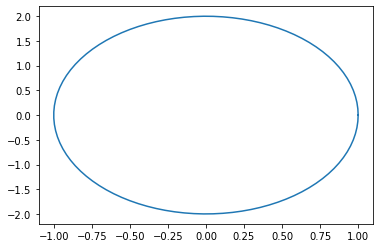

In [ ]:
plot_ellipsoid(c, A)

In [ ]:
#Compute ratio of volumes
V0 = np.pi / np.sqrt(np.linalg.det(P0))
vol_ratio = V / V0
print('Volume ratio:', vol_ratio)

Volume ratio: 4.0


#Case II

In [ ]:
#Define ellipsoid parameters
P0 = np.array([[1, 0], [0, 4]])
W = np.array([[0.5], [-0.5]])
c0 = np.array([[0], [0]])
A0 = np.linalg.inv(P0)

In [ ]:
#Compute minimum volume ellipsoid
V, c, A = ellipsoid_method(c0, A0, W)

In [ ]:
V

6.283185307179586

In [ ]:
#Compute ratio of volumes
V0 = np.pi / np.sqrt(np.linalg.det(P0))
vol_ratio = V / V0
print('Volume ratio:', vol_ratio)

Volume ratio: 4.0


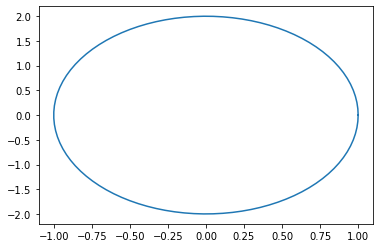

In [ ]:
plot_ellipsoid(c, A)

#Question 2: ADMM for Lasso (3pts)

Augmented Lagrangian:
$$ L_\rho(x,z,u) = \frac{1}{2} \| Ax - b \|^2_2 + \lambda \| z \|_1 + \frac{\rho}{2} \| x - z + u \|_2^2$$
where $z$ is an auxiliary variable and $u$ is the scaled dual variable. The ADMM algorithm updates $x$, $z$, and $u$ iteratively as follows:
$$x^{k+1} = \text{arg} \min_x \ L_\rho(x,z^k,u^k) = (A^TA + \rho I)^{-1}(A^Tb + \rho(z^k - u^k))$$
$$z^{k+1} = \text{arg} \min_z \ L_\rho(x^{k+1},z,u^k) = S_{\lambda/\rho}(x^{k+1} + u^k)$$
where $S_\gamma(x) = \text{sign}(x) \max(|x| - \gamma, 0)$ is the soft thresholding operator, and
$$u^{k+1} = u^k + x^{k+1} - z^{k+1}$$

In [ ]:
import numpy as np
import time
from sklearn.linear_model import Lasso

# Define problem parameters
n = 250
m = 75
A = np.random.normal(size=(m, n))
A /= np.linalg.norm(A, axis=0)
x_true = np.random.normal(size=n)
x_true[np.random.choice(n, n-5, replace=False)] = 0
b = A.dot(x_true) + np.random.normal(scale=1e-2, size=m)
lmbd = 0.1 * np.max(np.abs(A.T.dot(b)))

# Define ADMM algorithm with stopping criterion \|r^k\| <= tol
rho = 1.0
tol = 1e-4
x = np.zeros(n)
z = np.zeros(n)
u = np.zeros(n)
start_time = time.time()
for i in range(10000):
    # x-update
    x = np.linalg.solve(A.T.dot(A) + rho*np.identity(n), A.T.dot(b) + rho*(z - u))
    # z-update
    z_prev = z.copy()
    z = np.sign(x + u) * np.maximum(np.abs(x + u) - lmbd/rho, 0)
    # u-update
    u = u + x - z
    # Check convergence
    r = x - z
    if np.linalg.norm(r) <= tol:
        break
elapsed_time_admm = time.time() - start_time
print('first method')
print(f'X: {x}')

# Define coordinate descent method with tol=1e-4
lasso = Lasso(alpha=lmbd, tol=1e-4, fit_intercept=False)
start_time = time.time()
lasso.fit(A, b)
x_cd = lasso.coef_
elapsed_time_cd = time.time() - start_time
print('Second')
print(f'X: {}')

# Print results
print("ADMM with stopping criterion \|r^k\| <= tol:")
print("Iterations:", i+1)
print("CPU time:", elapsed_time_admm)
print("Primal residual:", np.linalg.norm(x - z))
print("True sparsity:", np.sum(x_true != 0))
print("Recovered sparsity:", np.sum(x != 0))
print("Relative error:", np.linalg.norm(x - x_true) / np.linalg.norm(x_true))

print("\nCoordinate descent with tol=1e-4:")
print("CPU time:", elapsed_time_cd)
print("Primal residual:", np.linalg.norm(A.dot(x_cd) - b))
print("True sparsity:", np.sum(x_true != 0))
print("Recovered sparsity:", np.sum(x_cd != 0))
print("Relative error:", np.linalg.norm(x_cd - x_true) / np.linalg.norm(x_true))


ADMM with stopping criterion \|r^k\| <= tol:
Iterations: 36
CPU time: 0.3991813659667969
Primal residual: 8.993100802945955e-05
True sparsity: 5
Recovered sparsity: 250
Relative error: 0.16915083818786045

Coordinate descent with tol=1e-4:
CPU time: 0.011888265609741211
Primal residual: 2.93747407446134
True sparsity: 5
Recovered sparsity: 0
Relative error: 1.0


#Question 3: Linear Programming Example(3 pts)

1. Formulate the problem as a linear program

Let $x_{ij}$ be the tons of cargo, where the raw index $i = 1,2,3,4$ for $C1, C2, C3, C4$ and \\
column index $j=$ compartment, $j=1$ is front, $j=2$ if centre, $j=3$ is rear.
The constraints:
* limit cargo:
\begin{split}
x_{11} + x_{12} + x_{13} &\leq 18 \\
x_{21} + x_{22} + x_{23} &\leq 15 \\
x_{31} + x_{32} + x_{33} &\leq 23 \\
x_{41} + x_{42} + x_{43} &\leq 12
\end{split}
* maximum weight of every compartment
\begin{split}
x_{11} + x_{21} + x_{31} + x_{41} &\leq 10 \\
x_{12} + x_{22} + x_{32} + x_{42} &\leq 16 \\
x_{13} + x_{23} + x_{33} + x_{43} &\leq 8
\end{split}
* maximum space
\begin{split}
480x_{11} + 650x_{21} + 580x_{31} + 390x_{41} &\leq 6800 \\
480x_{12} + 650x_{22} + 580x_{32} + 390x_{42} &\leq 8700 \\
480x_{13} + 650x_{23} + 580x_{33} + 390x_{43} &\leq 5300
\end{split}
*plane balance:
$$
\frac{x_{11} + x_{21} + x_{31} + x_{41}}{10} =
 \frac{x_{12} + x_{22} + x_{32} + x_{42}}{16} =
 \frac{x_{13}+x_{23}+x_{33}+x_{43}}{8}
$$
The objective funtion: \\
$$ \max 310(x_{11}+x_{12}+x_{13} + 380(x_{21}+x_{22}+x_{23}+350(x_{31}+x_{32}+x_{33}+285(x_{41}+x_{42}+x_{43}))))$$

2. What assumptions you made in formulating this problem as a linear program?

$x_{ij} \in \mathbb{R}$ \\
$x_{ij} > 0$

3. Solve the problem using scipy.optimize.linprog in Python.

In [4]:
from scipy.optimize import linprog
import numpy as np

In [5]:
c = [-310,-310,-310, -380,-380,-380, -350,-350,-350, -285,-285,-285]
A_ieq = np.array([[1,0,0, 1,0,0, 1,0,0, 1,0,0],
              [0,1,0, 0,1,0, 0,1,0, 0,1,0],
              [0,0,1, 0,0,1, 0,0,1, 0,0,1],
              [480,0,0, 650,0,0, 580,0,0, 390,0,0],
              [0,480,0, 0,650,0, 0,580,0, 0,390,0],
              [0,0,480, 0,0,650, 0,0,580, 0,0,390],
              [1,1,1, 0,0,0, 0,0,0, 0,0,0],
              [0,0,0, 1,1,1, 0,0,0, 0,0,0],
              [0,0,0, 0,0,0, 1,1,1, 0,0,0],
              [0,0,0, 0,0,0, 0,0,0, 1,1,1]])
b_ieq = [10,16,8,6800, 8700, 5300,18,15,23,12]

A_eq= [[1/10,-1/16,0, 1/10,-1/16,0, 1/10,-1/16,0, 1/10,-1/16,0],
      [1/10,0,-1/8, 1/10,0,-1/8, 1/10,0,-1/8, 1/10,0,-1/8],
      [0,1/16,-1/8, 0,1/16,-1/8, 0,1/16,-1/8, 0,1/16,-1/8]]

b_eq = [0, 0, 0]

res = linprog(c, A_ub=A_ieq, b_ub=b_ieq,  A_eq=A_eq, b_eq=b_eq,options={"disp": False})
tot_profit = -res.fun
print(f"The maximum profit: {-res.fun}")

The maximum profit: 12151.57894736842


In [6]:
res.x

array([ 0.        ,  0.        ,  0.        , 10.        ,  0.        ,
        5.        ,  0.        , 12.94736842,  3.        ,  0.        ,
        3.05263158,  0.        ])

4. Solve the problem using the ellipsoid method. Plot the graph showing how the ellipsoid
volume decreases. Count the number of iterations.

In [ ]:
import numpy as np

def ellipsoid_method(c, A, b, eps=1e-6, max_iter=1000):
    """
    Solve the linear program:
    minimize c^T x
    subject to A x <= b
    using the Ellipsoid method.
    """
    n, m = A.shape
    R = np.sqrt(n) * np.max(np.linalg.norm(A, axis=1)) # Initial ellipsoid radius
    x = np.zeros(m) # Initial center of the ellipsoid

    for i in range(max_iter):
        if np.sqrt(np.dot(c, c)) / R < eps:
            break
        y = np.dot(A, x) - b
        if np.max(y) > 0:
            j = np.argmax(y)
            x = x - ((R / np.sqrt(np.dot(A[j], A[j]))) * A[j])
            R = R * np.sqrt(1 - np.dot(A[j], A[j]) / (n * np.dot(A[j] / np.linalg.norm(A[j]), A[j] / np.linalg.norm(A[j]))))
        else:
            break

    return x, i


In [ ]:
A = np.array([[1,1,1,0,0,0,0,0,0,0,0,0],[0,0,0,1,1,1,0,0,0,0,0,0],
             [0,0,0,0,0,0,1,1,1,0,0,0],[0,0,0,0,0,0,0,0,0,1,1,1],
             [1,0,0,1,0,0,1,0,0,1,0,0],[0,1,0,0,1,0,0,1,0,0,1,0],
             [0,0,1,0,0,1,0,0,1,0,0,1],[480,0,0,650,0,0,580,0,0,390,0,0],
             [0,480,0,0,650,0,0,580,0,0,390,0],[0,0,480,0,0,650,0,0,580,0,0,390]])

b = np.array([18,15,23,12,10,16,8,6800,8700,5300])

# objective coeficients
c = np.array([-310,-310,-310,-380,-380,-380,-350,-350,-350,-285,-285,-285])
x, i = ellipsoid_method(c, A, b, eps=1e-6, max_iter=1000)
print(x, i)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] 0


5. Sensitivity to the constraint values. What if the available cargoes weight increases/decreases
by 10%? Define which cargo weight has the greatest impact on the total profit. Explain
the dependence between dual variables and changes in the total profit.

In [ ]:
for i in range(1,5):
    b_ieq = [10,16,8,6800, 8700, 5300,18,15,23,12]
    b_ieq[-i] = b_ieq[-i]*0.9
    res = linprog(c, A_ub=A_ieq, b_ub=b_ieq,  A_eq=A_eq, b_eq=b_eq,options={"disp": False})
    print(f"Cargo {5-i} decrease by 10%, profit:  {100* abs(tot_profit+res.fun)/tot_profit}%")
    b_ieq[-i] = b_ieq[-i]*1.1
    res = linprog(c, A_ub=A_ieq, b_ub=b_ieq,  A_eq=A_eq, b_eq=b_eq,options={"disp": False})
    print(f"Cargo {5-i} increase by 10%, profit:  {100*abs(tot_profit+res.fun)/tot_profit}%\n")
    
    

Cargo 4 decrease by 10%, profit:  0.0%
Cargo 4 increase by 10%, profit:  0.0%

Cargo 3 decrease by 10%, profit:  0.0%
Cargo 3 increase by 10%, profit:  0.0%

Cargo 2 decrease by 10%, profit:  0.37032224532224534%
Cargo 2 increase by 10%, profit:  0.03703222453222454%

Cargo 1 decrease by 10%, profit:  0.0%
Cargo 1 increase by 10%, profit:  0.0%

